# Molecular Dynamics
## Lecture 22

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy as sp
sp.init_printing()
from ipywidgets import interact
from IPython.display import display
plt.style.use('default')

In this lecture we will consider the mechanics of multiparticle systems. The methods are applicable to any system with a large number of particles, such as
* droplets in an aerosol
* particles in a flame
* stars in a galaxy
* motion of molecules (hence the name, molecular dynamics)

## Verlet method

The equations of motions of each particle $i$ is

\begin{align}
\frac{d v_{i,x}}{dt} &= a_{i,x}  \\
\frac{d x_{i}}{dt} &= v_{i,x} \\
\frac{d v_{i,y}}{dt} &= a_{i,y}  \\
\frac{d y_{i}}{dt} &= v_{i,y} \\
\end{align}

where the $v_{i,x}$ and $v_{i,y}$ are the velocity components of the $i$-th particle located at position $(x_i, y_i)$.


A common second-order numerical method for solving such systems is give the Verlet method:

\begin{align}
x_i[n+1] &= 2 x_i[n] - x_i [n-1] + a_{i,x} [n] (\Delta t)^2  \\
v_{i,x} [n] &= \frac{x_i[n+1] - x_i[n-1] }{2\Delta t} 
\end{align}

with similar equations for $y_i$ and $v_{i,y}$.  The Verlet method can be derived starting from the central difference approximation for a second derivative:

$$
\frac{d^2 x_i}{dt^2} \approx \frac{x_i[n+1] + x_i[n-1] - 2 x_i[n]}{(\Delta t)^2}
$$

### Lennard-Jones Potential

In previous lectures, we considered the gravitational interaction between celestial bodies.  For molecules, the attractive forces are given by Van der Waals forces.  As atoms get close, there is a repulsive force due to the overlap of their electron clouds.  

This can be modelled with the Lennard-Jones potential:

$$ U(r) = 4 \epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} -  \left(\frac{\sigma}{r}\right)^{6} \right] $$

where $\epsilon$ and $\sigma$ are constants that set the energy and distance scales associated with the interaction.

In [2]:
r = sp.Symbol('r')
U = 4*((1/r)**12 - (1/r)**6)

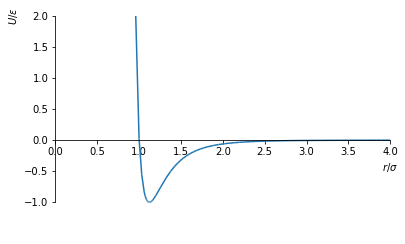

In [3]:
sp.plot(U, (r, 0, 4), ylim=(-1.5, 2), ylabel = "$U / \epsilon$", xlabel="$r/\sigma$")

To initialize our system, we could randomly distribute the particles:

In [4]:
def random(N):
    x = np.zeros(N)
    y = np.zeros(N)
    for i in range(N):
        x[i] = (np.random.rand() - 0.5) * np.sqrt(2)
        y[i] = (np.random.rand() - 0.5) * np.sqrt(2)
        plt.plot(x[i],y[i], 'o')


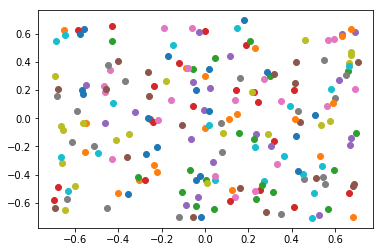

In [5]:
random(200)

However, atoms are not truely randomly positioned. Two atoms can never be very close to each other. One way to solve this is to consider a lattice (grid) of position initial positions:

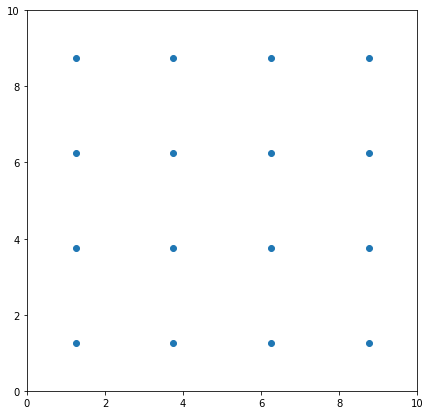

In [6]:
def lattice(N, L):
    # organize the particles in to a grid
    sqn=np.sqrt(N)
    if (sqn == int(sqn)):
        grid = 0.5*L/sqn
    else: 
        grid = 0.5*L / int(sqn + 1)
       
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = grid
    y[0] = grid
    for i in range(N-1):
        
        if x[i+1] < L:
            x[i+1] = x[i] + 2*grid
            y[i+1] = y[i]
        if x[i+1] >= L:
            x[i+1] = grid
            y[i+1] = y[i]+2*grid
    
    return x, y
   
N = 16
L = 10
x, y = lattice(N, L)
fig, axes = plt.subplots(figsize=(7,7))
plt.plot(x,y, 'o')
plt.xlim(0, L)
plt.ylim(0, L)
plt.show()

We also can perturb each particle slightly from its grid position

In [7]:
def random_lattice(n, L):
    # organize the particles in to a grid
    sqn=np.sqrt(n)
    if (sqn == int(sqn)):
        grid = 0.5*L/sqn
    else: 
        grid = 0.5*L / int(sqn + 1)
       
    # random perturbation to gridded position
    drandom = lambda: 0.25*grid*(np.random.rand() - 0.5) * np.sqrt(2)
    
    x = np.zeros(n)
    y = np.zeros(n)
    x[0] = grid + drandom()
    y[0] = grid + drandom()
    for i in range(n-1):
        
        if x[i+1] < L:
            x[i+1] = x[i] + 2*grid + drandom()
            y[i+1] = y[i] + drandom()
        if x[i+1] >= L:
            x[i+1] = grid + drandom()
            y[i+1] = y[i]+2*grid + drandom()
    
    return x, y

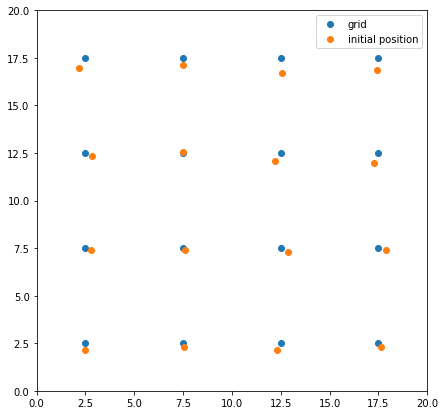

In [8]:
fig, axes = plt.subplots(figsize=(7,7))

N = 16
L = 20

x_grid, y_grid = lattice(N, L)
plt.plot(x_grid, y_grid, 'o', label = 'grid')

x, y = random_lattice(N, L)
plt.plot(x, y, 'o', label = 'initial position')

plt.xlim(0, L)
plt.ylim(0, L)
plt.legend()

plt.show()

We also need to initialize the initial velocities

In [9]:
v0 = 1.0 # maximum velocity

vx = 2*(np.random.rand(N) - 0.5)
vy = 2*(np.random.rand(N) - 0.5)

Finally, for the Verlet method, we the need the (fictious) previous position.  We can calculate this as

In [10]:
dt = 0.02

x_prev = x - vx * dt
y_prev = y - vy * dt

The Verlet method can calculate the subsequent position and velocities of all the particles given all the accelerations.

These accelerations are given by the forces due to all of the forces acting on the particles.

\begin{align}
a_{j, x} &= \frac{1}{m} \sum_{k \neq j}  f_{k,j} \cos \theta_{k, j}\\
a_{j, y} &= \frac{1}{m} \sum_{k \neq j}  f_{k,j} \sin \theta_{k, j}\\
\end{align}

where $f_{k, j}$ and $\theta_{k,j}$ is the magnitude and direction, respectively, of the pairwise interaction force between two particles.

The pairwise force is given by

$$ f_{k,j} = - \frac{ \partial U} {\partial r_{k,j} } = 24 \left( \frac{2}{r_{k,j}^{13}} - \frac{1}{r_{k,j}^7} \right) $$

where $r_{k, j}$ is the distance between particles.

In [63]:
import numba
import time

In [64]:
#@numba.jit
def F(x1, y1, x2, y2, L):
    # calculate pairwise force between (x1, y1) and (x2, y2)
    
    time.sleep(100.0)
    
    dx = abs(x2-x1)
    dx = min(L-dx, dx)
    dy = abs(y2-y1)
    dy = min(L-dy, dy)
    
    r = np.sqrt(dx**2 + dy**2)
    
    if r > 3:
        return 0, 0
    
    f = 24 * (2 / r**13 - 1/r**7)
    
    # fx = f cos(θ)
    fx = f * (x2-x1) / r
    # fy = f sin(θ)
    fy = f * (y2-y1) / r
    
    return fx, fy

In [65]:
F(0, 0, 9, 1, 10)

In [66]:
%%timeit
F(0, 0, 1, 1, 10)

1 s ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The net force is calculated by summing up all of the components

In [32]:
#@numba.jit
def net_force(x, y, L):
    n = len(x)
    fx_net = np.zeros(n)
    fy_net = np.zeros(n)
    for k in range(n):
        for j in range(n):
            if k != j:
                fx, fy = F(x[k], y[k], x[j], y[j], L)
                fx_net[j] += fx
                fy_net[j] += fy
                
    return fx_net, fy_net

We can now apply the Verlet method to calculate the evolution of the system

In [33]:
#@numba.jit
def Verlet(n=20, L=10, v0=1, tmax=100, dt=0.02):
    
    # initial position
    x0, y0 = random_lattice(n, L)

    # initial velocity
    vx0 = 2*(np.random.rand(n) - 0.5)
    vy0 = 2*(np.random.rand(n) - 0.5)
    
    # previous position
    x_prev0 = x0 - vx0 * dt
    y_prev0 = y0 - vy0 * dt
    
    N = round(tmax/dt)
    
    # allocate memory for n particles over N timesteps
    x = np.zeros((N, n))
    y = np.zeros((N, n))
    vx = np.zeros((N, n))
    vy = np.zeros((N, n))
    
    x[0, :] = x_prev0  # previous position
    y[0, :] = y_prev0
    x[1, :] = x0  # current position
    y[1, :] = y0
    vx[1, :] = vx0 
    vy[1, :] = vy0 
    
    for i in range(1, N-1):

        fx, fy = net_force(x[i,:], y[i,:], L)
        
        x[i+1,:] = 2 * x[i,:] - x[i-1,:] + fx * dt**2
        y[i+1,:] = 2 * y[i,:] - y[i-1,:] + fy * dt**2
        
        vx[i+1,:] = (x[i+1,:] - x[i,:])/(dt)
        vy[i+1,:] = (y[i+1,:] - y[i,:])/(dt)
        
        # periodic boundary conditions
        for j in range(n):
            if x[i+1, j] < 0:
                x[i+1, j] += L
            if x[i+1, j] > L:
                x[i+1, j] -= L
            if y[i+1, j] < 0:
                y[i+1, j] += L
            if y[i+1, j] > L:
                y[i+1, j] -= L
        
   # vx[N-1, :] = (x[N-1,:] - x[N-2,:])/(dt)
   # vy[N-1, :] = (y[N-1,:] - y[N-2,:])/(dt)
    
    return x, y, vx, vy

In [43]:
%%time
x, y, vx, vy = Verlet(n=6, tmax=20, v0=1)

CPU times: user 214 ms, sys: 5.92 ms, total: 220 ms
Wall time: 221 ms


In [35]:
%%time
x, y, vx, vy = Verlet(n=50)  # old, not jit

CPU times: user 58.5 s, sys: 315 ms, total: 58.8 s
Wall time: 59.5 s


In [28]:
%%time
x, y, vx, vy = Verlet(n=25)

CPU times: user 427 ms, sys: 7.26 ms, total: 434 ms
Wall time: 440 ms


Profile

In [340]:
%%prun
x, y, vx, vy = Verlet(n=100)

Discuss different programming languages

* Interpreted

* Compiled

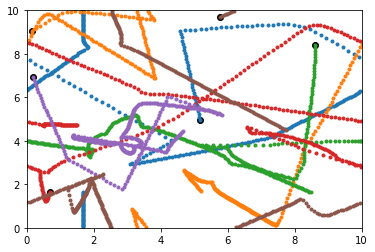

In [44]:
fig, axes = plt.subplots()
N, n = x.shape

plt.plot(x[-1, :], y[-1, :], 'ko')
for i in range(n):
    plt.plot( x[::3, i], 
              y[::3, i], '.')
    
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.show()

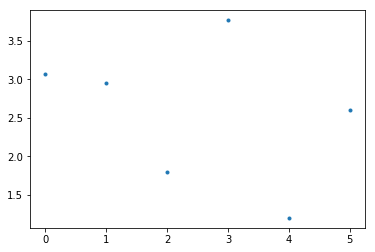

In [54]:
v = np.sqrt(vx**2 + vy**2)
v_avg = np.mean(v, 0)
plt.plot(v_avg, '.')

In [53]:
v.shape